<a href="https://colab.research.google.com/github/Someya-Gaku/Python_study/blob/main/SIGNATE-practice1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab上でSignate APIキーを使用するための準備
 "https://signate.jp/account_settings#" より、APIトークンを取得し、ファイルをGoogleDriveに保存する。

> 参考サイト: Google ColabでSIGNATE APIを使う
>
>(https://qiita.com/insilicomab/items/d757339d97b44feaff01)

In [165]:
!pip install signate

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [166]:
# 使えるコマンド一覧
!signate --help

Usage: signate [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  download  Download the file of competition
  files     List file of competition
  list      List competition
  submit    Submit a result file to the competition
  token     Download the API Token


In [167]:
# SIGNATEに存在するデータセットの確認 (2023/12/26 時点)
!signate list

  competitionId  title                                                                             closing     prize              submitters
---------------  --------------------------------------------------------------------------------  ----------  ---------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                              -                                    6945
             24  【練習問題】お弁当の需要予測                                                      -                                    8403
             27  【練習問題】Jリーグの観客動員数予測                                               -                                    2062
            100  【練習問題】手書き文字認識                                                        -           Knowledge                 341
            102  【練習問題】タイタニックの生存予測                                                -           Knowledge                2556
            103  【練習問題】音楽ラベリング                                                        -     

今回は competitionId が "1" の 銀行の顧客ターゲティング のデータセットを用いる



In [168]:
# competitionId が 1 の データセットの中身を確認
!signate files --competition-id=1

  fileId  name               title              size  updated_at
--------  -----------------  --------------  -------  -------------------
       1  train.csv          学習用データ    2345067  2016-05-31 20:19:48
       2  test.csv           評価用データ    1523536  2021-11-02 12:16:31
       3  submit_sample.csv  応募用サンプル   205890  2016-05-31 20:20:59


In [169]:
# competitionIdが 1　の データセットをダウンロード
!signate download --competition-id=1

submit_sample.csv

test.csv

train.csv


Download completed.


今回はzip形式で圧縮されているファイルがある場合は **!unzip ○○.zip** で解凍する

また、追加で --file-id=○○ を指定して、特定のIDから特定のファイルIDに対応するデータのみをダウンロード可能

In [170]:
%ls

 sample_data/            'submit_sample (2).csv'  'test (1).csv'   test.csv        'train (3).csv'
 signate.csv             'submit_sample (3).csv'  'test (2).csv'  'train (1).csv'   train.csv
'submit_sample (1).csv'   submit_sample.csv       'test (3).csv'  'train (2).csv'


↑現在のディレクトリ状況

./ｘｘｘ/ のように入力すると、データｘｘｘを読み込み

# 今回用いるデータの概要

>「使用するデータは、ある銀行の顧客属性データおよび、過去のキャンペーンでの接触情報、などで、これらのデータを元に、当該のキャンペーンの結果、口座を開設したかどうかを予測します。」

>「学習用のデータは、27,168名の顧客データとキャンペーンの結果（口座開設の有無）です。予測する対象は、18,083名のキャンペーンに対する反応（結果）を予測していただきます。」

※ https://signate.jp/competitions/1 より引用

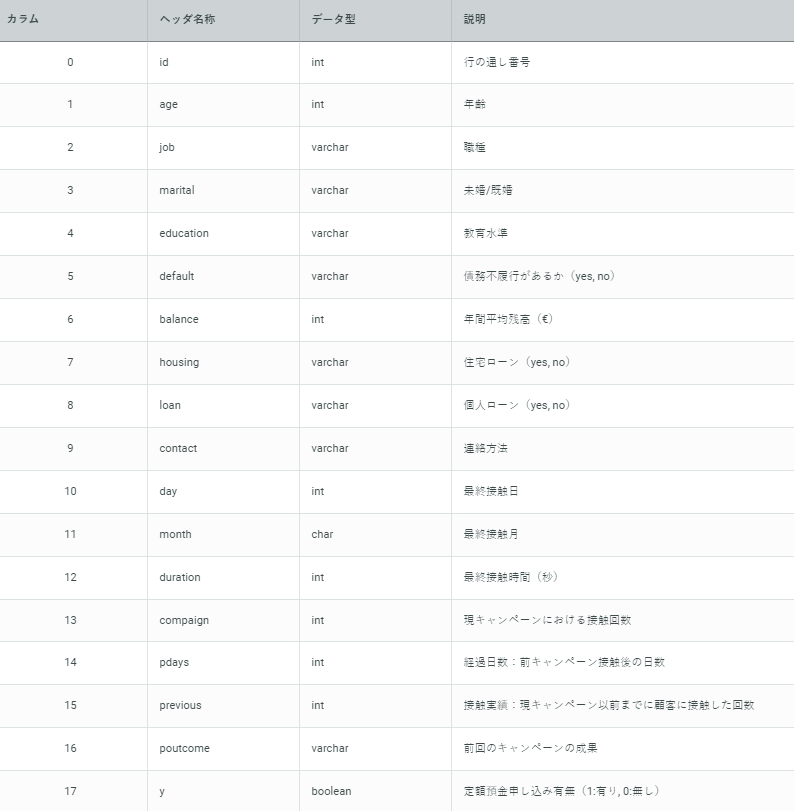

# 探索的データ分析 (EDA)

## ライブラリのインポート

In [171]:
# ベースとなるライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

#各種データの読み込み
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

# 出力結果における "FutureWarning" の非表示化
import warnings
warnings.simplefilter('ignore', FutureWarning)

## データの中身を確認

### 欠損値の確認

In [172]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27128 non-null  int64 
 1   age        27128 non-null  int64 
 2   job        27128 non-null  object
 3   marital    27128 non-null  object
 4   education  27128 non-null  object
 5   default    27128 non-null  object
 6   balance    27128 non-null  int64 
 7   housing    27128 non-null  object
 8   loan       27128 non-null  object
 9   contact    27128 non-null  object
 10  day        27128 non-null  int64 
 11  month      27128 non-null  object
 12  duration   27128 non-null  int64 
 13  campaign   27128 non-null  int64 
 14  pdays      27128 non-null  int64 
 15  previous   27128 non-null  int64 
 16  poutcome   27128 non-null  object
 17  y          27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


この train.csv は全てが non-null であり、欠損値が無い綺麗なデータであることが分かる

In [173]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18083 entries, 0 to 18082
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         18083 non-null  int64 
 1   age        18083 non-null  int64 
 2   job        18083 non-null  object
 3   marital    18083 non-null  object
 4   education  18083 non-null  object
 5   default    18083 non-null  object
 6   balance    18083 non-null  int64 
 7   housing    18083 non-null  object
 8   loan       18083 non-null  object
 9   contact    18083 non-null  object
 10  day        18083 non-null  int64 
 11  month      18083 non-null  object
 12  duration   18083 non-null  int64 
 13  campaign   18083 non-null  int64 
 14  pdays      18083 non-null  int64 
 15  previous   18083 non-null  int64 
 16  poutcome   18083 non-null  object
dtypes: int64(8), object(9)
memory usage: 2.3+ MB


この train.csv も全てが non-null であり、欠損値が無い綺麗なデータであることが分かる

### 基本統計量の確認

In [174]:
train.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000
mean,13564.500000,40.951010,1355.800870,15.806215,260.711295,2.751769,40.528052,0.579733,0.117001
std,7831.323388,10.608542,3003.305272,8.337904,260.091727,3.126594,100.382462,2.503653,0.321427
min,1.000000,18.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6782.750000,33.000000,72.000000,8.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,13564.500000,39.000000,449.000000,16.000000,182.000000,2.000000,-1.000000,0.000000,0.000000
75%,20346.250000,48.000000,1428.000000,21.000000,323.000000,3.000000,-1.000000,0.000000,0.000000
max,27128.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [175]:
test.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,18083.000000,18083.000000,18083.000000,18083.000000,18083.000000,18083.000000,18083.000000,18083.000000
mean,9042.000000,40.914008,1371.980092,15.806725,254.340264,2.781950,39.702428,0.581209
std,5220.256794,10.634331,3105.985293,8.299509,253.591981,3.054651,99.747634,1.965265
min,1.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,4521.500000,33.000000,72.000000,8.000000,102.000000,1.000000,-1.000000,0.000000
50%,9042.000000,39.000000,447.000000,16.000000,178.000000,2.000000,-1.000000,0.000000
75%,13562.500000,48.000000,1427.000000,21.000000,314.000000,3.000000,-1.000000,0.000000
max,18083.000000,95.000000,98417.000000,31.000000,3881.000000,50.000000,854.000000,58.000000


* balance (年間平均残高(€)) の mean(平均) と 50%(中央値) が離れており、かつ mean の方が大きい数値

→  **「一部の人の残高が高額」**であると推測できる。

### カテゴリデータの確認

In [176]:
train.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,27128,27128,27128,27128,27128,27128,27128,27128,27128
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,5886,16411,13882,26644,15125,22788,17580,8317,22150


In [177]:
test.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,18083,18083,18083,18083,18083,18083,18083,18083,18083
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,3846,10803,9320,17752,10005,15179,11705,5449,14809


* default (債務不履行があるか(yes, no) ) の大半が no

* poutcome (前回のキャンペーンの成果) の大半も unknown

* month (最終接触月) は may (5月) が最も多い

→ month 等においては、キャンペーンにおける開始月や終了月などの可能性があり、キャンペーンの結果、口座を開設したかどうかについて、あまり影響が無い可能性がある。

---

※ 具体的なデータの中身は次の "特定のデータの種類と数を確認" で改めて確認する

### 特定のデータの種類と数を確認

In [178]:
train.value_counts()

id     age  job            marital   education  default  balance  housing  loan  contact    day  month  duration  campaign  pdays  previous  poutcome  y
1      39   blue-collar    married   secondary  no       1756     yes      no    cellular   3    apr    939       1         -1     0         unknown   1    1
18069  53   technician     divorced  secondary  no       453      no       no    cellular   17   nov    148       2         -1     0         unknown   0    1
18093  51   management     divorced  tertiary   no       1028     no       no    cellular   5    aug    178       4         -1     0         unknown   0    1
18092  29   self-employed  single    tertiary   no       16       yes      no    unknown    6    may    43        1         -1     0         unknown   0    1
18091  40   technician     married   secondary  no       265      no       no    unknown    18   jun    1365      4         -1     0         unknown   0    1
                                                         

In [179]:
test.value_counts()

id     age  job          marital  education  default  balance  housing  loan  contact    day  month  duration  campaign  pdays  previous  poutcome
1      30   management   single   tertiary   no        1028    no       no    cellular   4    feb    1294      2         -1     0         unknown     1
12053  36   technician   married  tertiary   no        508     no       no    cellular   22   aug    233       4         -1     0         unknown     1
12059  55   technician   married  secondary  no        3899    yes      no    telephone  28   jul    596       4         -1     0         unknown     1
12058  34   unemployed   married  secondary  no        438     yes      yes   cellular   9    apr    272       1          323   1         failure     1
12057  40   blue-collar  single   secondary  no        1       yes      no    unknown    8    may    190       1         -1     0         unknown     1
                                                                                             

In [180]:
train["job"].value_counts()

blue-collar      5886
management       5620
technician       4491
admin.           3085
services         2506
retired          1391
self-employed     945
entrepreneur      914
unemployed        790
housemaid         765
student           557
unknown           178
Name: job, dtype: int64

In [181]:
test["job"].value_counts()

blue-collar      3846
management       3838
technician       3106
admin.           2086
services         1648
retired           873
self-employed     634
entrepreneur      573
unemployed        513
housemaid         475
student           381
unknown           110
Name: job, dtype: int64

In [182]:
train["contact"].value_counts()

cellular     17580
unknown       7861
telephone     1687
Name: contact, dtype: int64

In [183]:
test["contact"].value_counts()

cellular     11705
unknown       5159
telephone     1219
Name: contact, dtype: int64

In [184]:
train["month"].value_counts()

may    8317
jul    4136
aug    3718
jun    3204
nov    2342
apr    1755
feb    1586
jan     846
oct     439
sep     356
mar     299
dec     130
Name: month, dtype: int64

In [185]:
test["month"].value_counts()

may    5449
jul    2759
aug    2529
jun    2137
nov    1628
apr    1177
feb    1063
jan     557
oct     299
sep     223
mar     178
dec      84
Name: month, dtype: int64

In [186]:
train["poutcome"].value_counts()

unknown    22150
failure     2969
other       1123
success      886
Name: poutcome, dtype: int64

In [187]:
test["poutcome"].value_counts()

unknown    14809
failure     1932
other        717
success      625
Name: poutcome, dtype: int64

*  母数が減っている影響でそれぞれの値が減ってはいるが、比率的には大差はない

*  どの項目においても unknown が一定数ある

* month (最終接触月) は、may (5月) と dec (12月) で大きな差がある

* poutcome (前回のキャンペーンの成果) においては、unknown が大半を占めていたが、内訳を見ると failure (失敗) の方が success (成功) よりも多い

## データの中身の分析 (可視化)

### 各特徴量をヒストグラムで可視化


array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>],
       [<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>],
       [<Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'y'}>]], dtype=object)

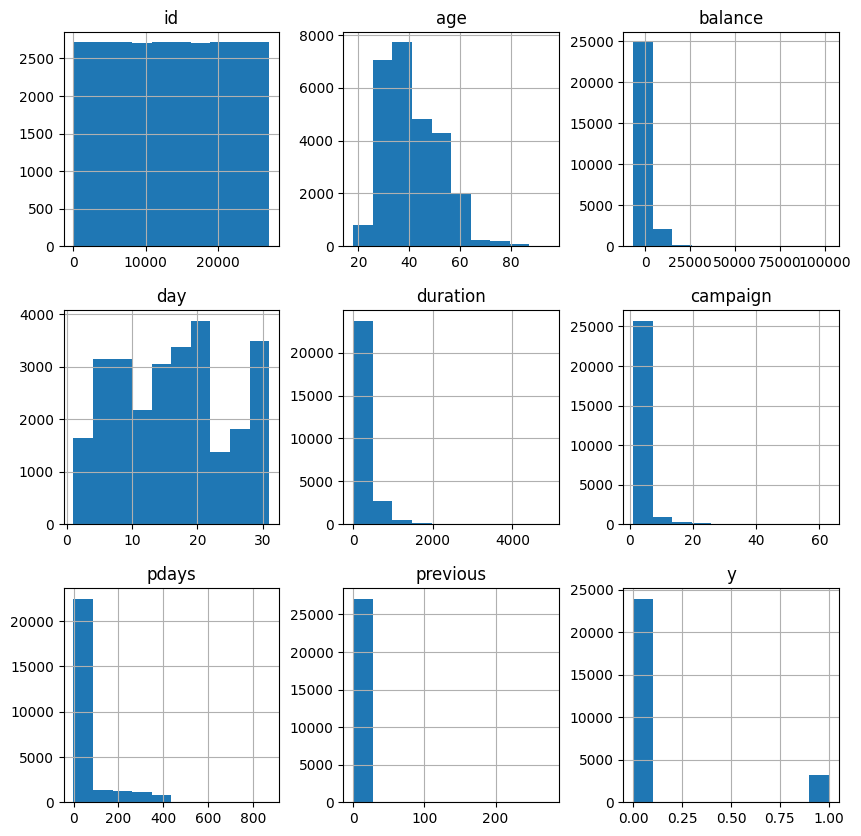

In [188]:
train.hist(figsize=(10,10))

* y (定額預金申し込み有無（1:有り, 0:無し）) にかなりのばらつきあり  →  不均衡なデータ

* 30代付近の人が多い

* age, balance, duration, campaign, pdays, previousは正しく前処理する必要がありそう

### 相関係数をヒートマップで可視化

<Axes: >

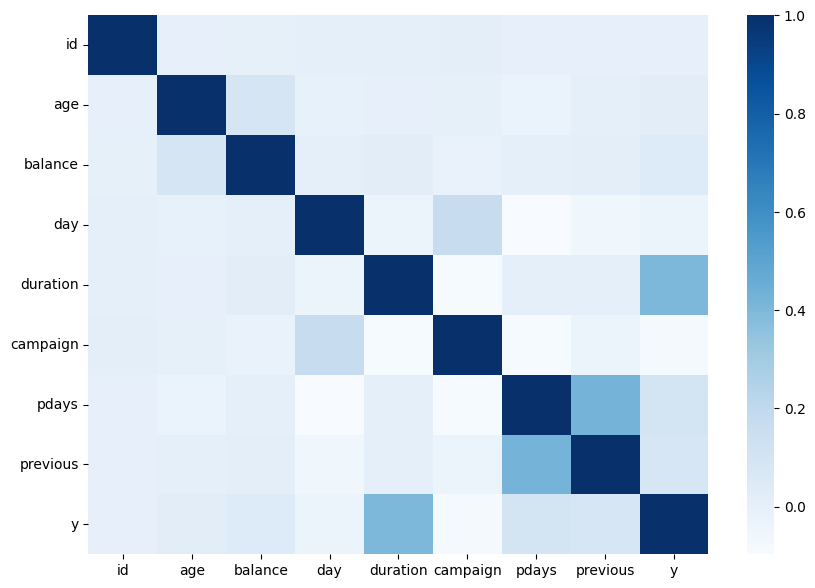

In [189]:
plt.figure(figsize=(10, 7))
sns.heatmap(train.corr(), cmap = "Blues")

* y (定額預金申し込み有無（1:有り, 0:無し)) と duration (最終接触時間(秒)) の相関が高い

* blance (年間平均残高（€)) と pdays (経過日数：前キャンペーン接触後の日数) も y (定額預金申し込み有無（1:有り, 0:無し)) と多少の相関がある

* previous (現キャンペーン以前までに顧客に接触した回数) と pdays (経過日数：前キャンペーン接触後の日数) の相関が高い

### 特徴量間分布の可視化

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


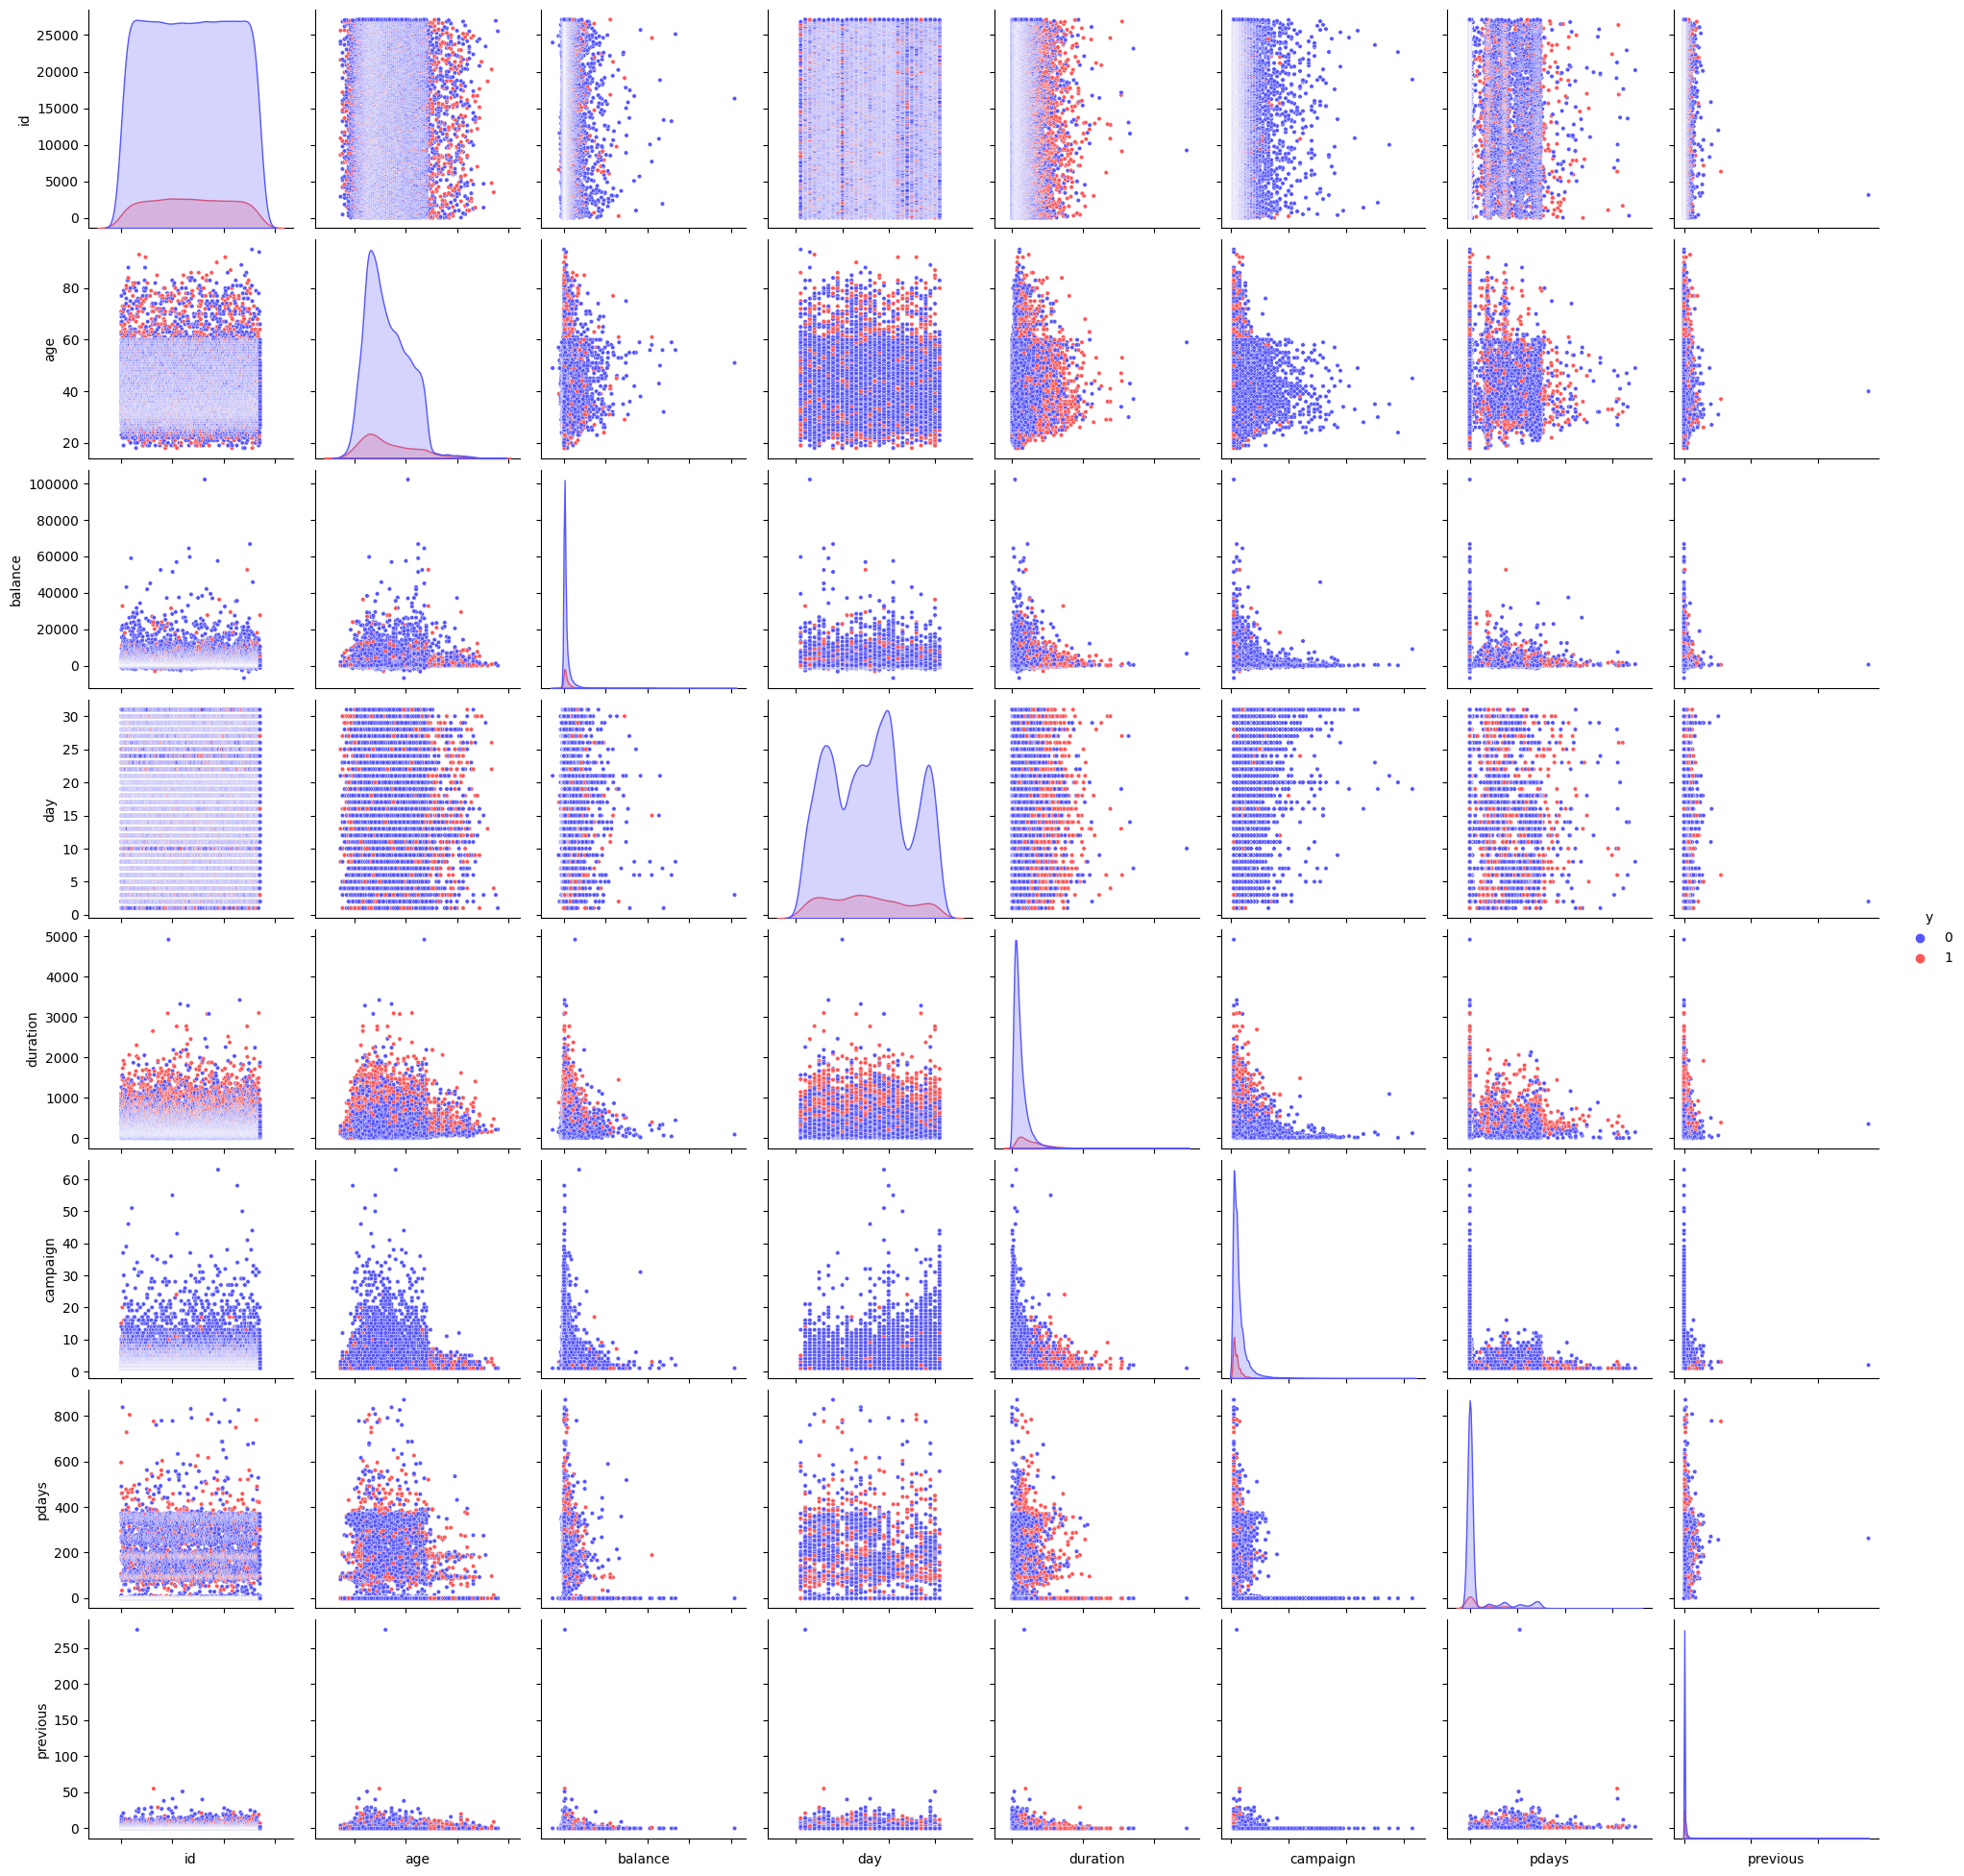

In [190]:
g = sns.pairplot(train, hue='y', palette = 'seismic',size=2.5,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

* age (年齢) が若い方が yが1,0ともに高い。

* duration（接触時間）が少ない方が y が 0 （定額預金申し込みが無い）となる割合が高い。

同じく、
* campaign (現キャンペーンにおける接触回数) が少ないと、y が 0 となる割合が高い。


### オブジェクト型の特徴量とyの相関関係の可視化

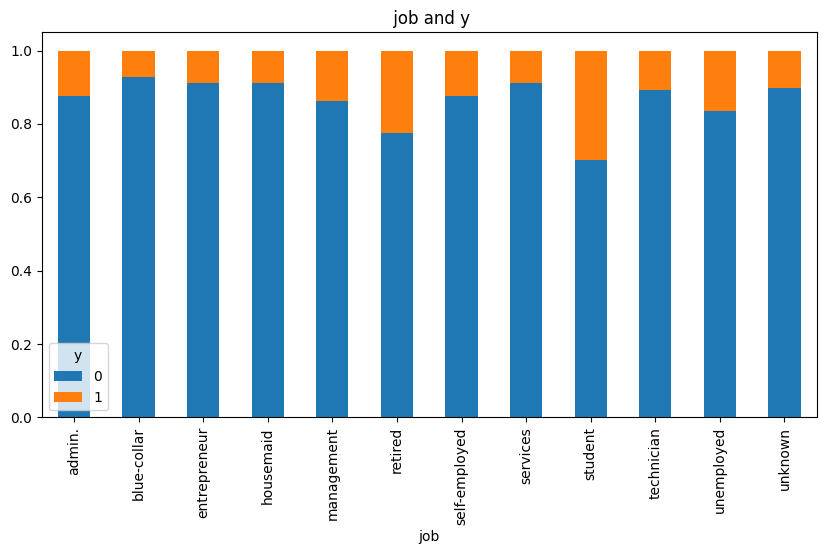

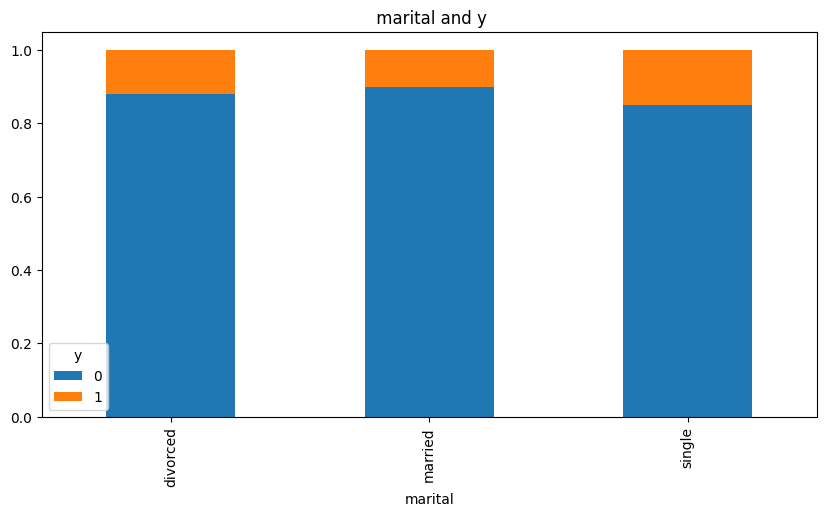

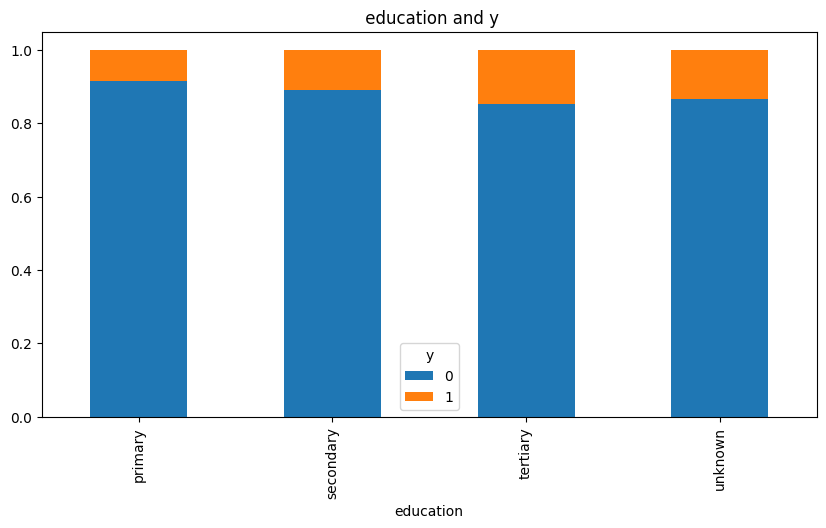

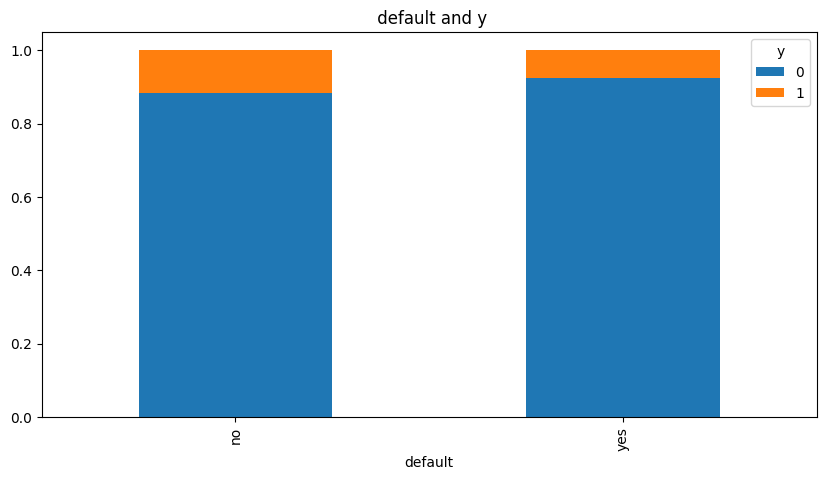

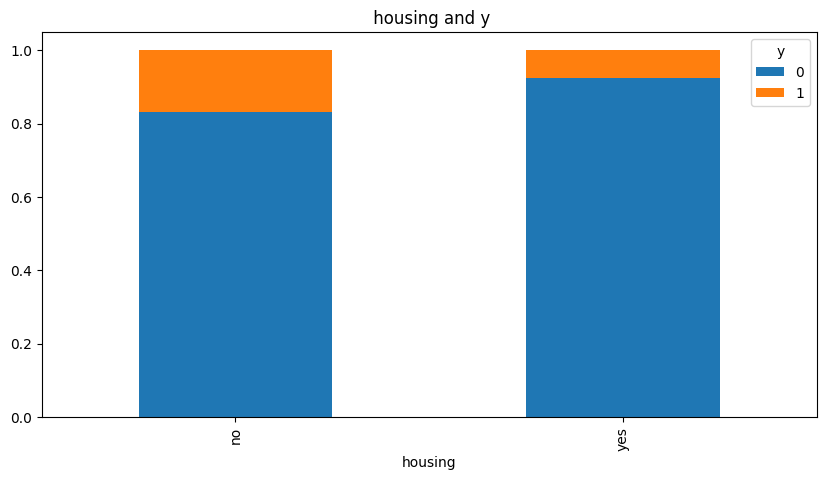

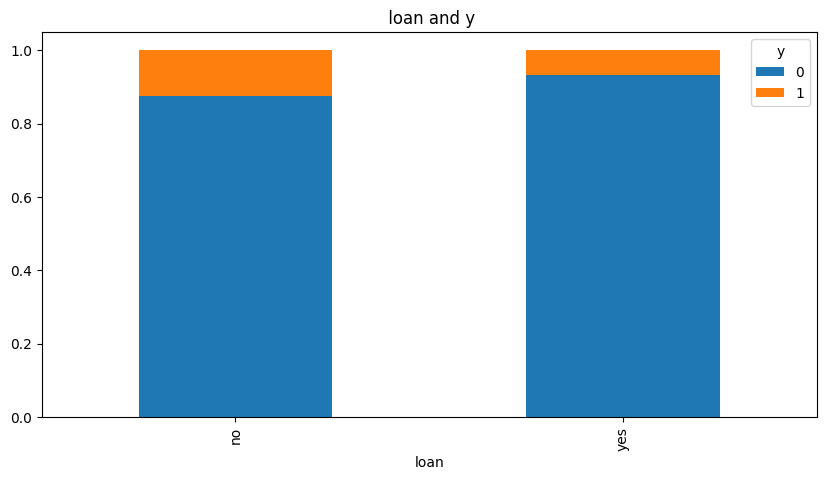

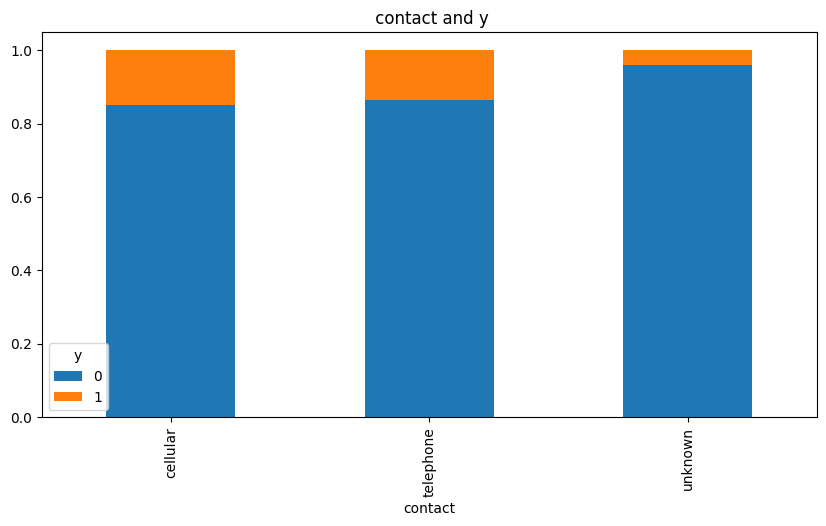

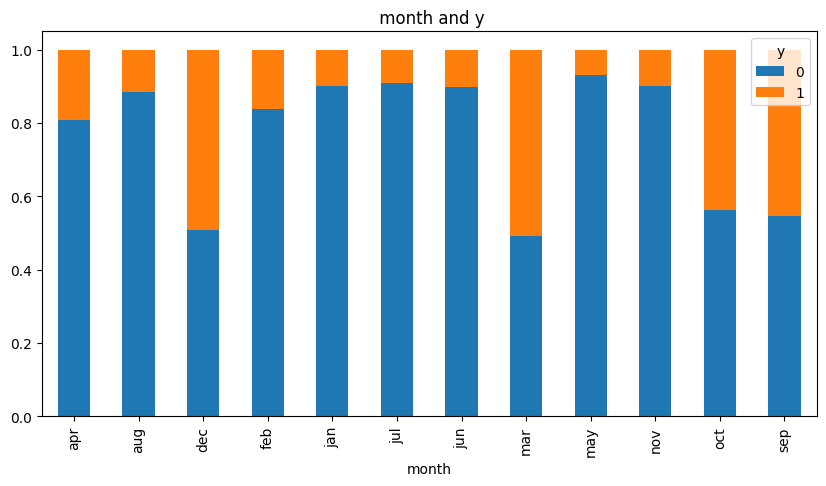

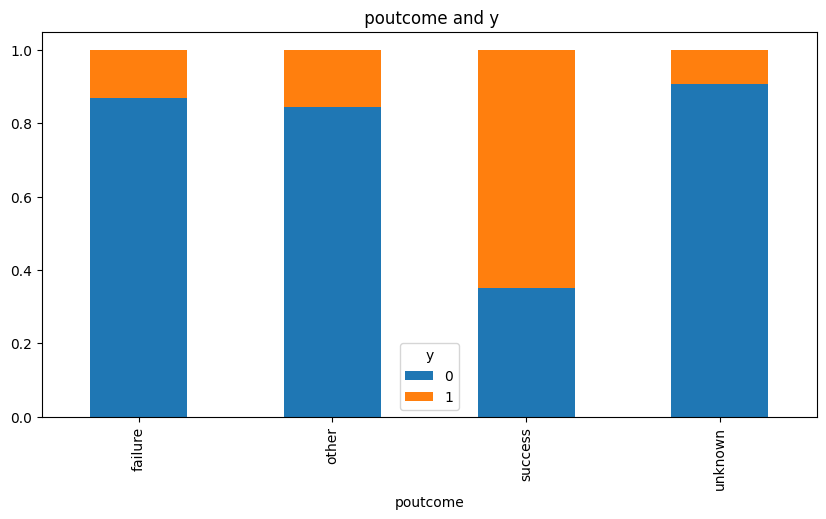

In [191]:
columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for column in columns:
    math = pd.crosstab(train[column], train['y'], normalize='index')

    math.plot(kind='bar', stacked=True, figsize=(10, 5))
    plt.title(f" {column} and y")
    plt.show()

上から順に読み取れたことを以下に示す

---
１．job (職種) と y

* retired(退職済み)とstudent(学生) は y が 1 である割合が多い

→ 現時点で(学生を含む)職を持たない人へのキャンペーン成功率が高い

---
２．marital (未婚/既婚) と y

* 僅かに未婚の方の方が y が 1 となっている割合が多い

※ 僅かである為、これだけではその傾向があるとは言えない

---

３．education (教育水準) と y

* 教育水準が上がるにつれて僅かに y が 1 となる増加傾向が見られる

---

４．default (債務不履行があるか（yes, no) ) と y

* 債務不履行がない人の方が僅かに y が 1 となる割合が多い

※ 傾向がありそうだが、微妙な差であるため確かではない

---

５．housing (住宅ローン（yes, no) )と y

* 住宅ローンを借りていない人のほうが y が 1 となる割合が多い

---

６．loan (個人ローン (yes, no) ) と y

* 個人ローンを借りていない人のほうが y が 1 となる割合が多い

※ 上述の「５．housing と y」と同様

---

７．contact (連絡方法) と y

* 下記の比率を考慮すると、連絡手段として携帯電話を用いると y が 1 となる割合が多くなると分かる

In [192]:
test["contact"].value_counts()

cellular     11705
unknown       5159
telephone     1219
Name: contact, dtype: int64

---
８．month (最終接触月) と y

* 特定の月 (sep(9月), oct(10月), dec(12月), mar(3月)) のみ極端に y が 1となる割合が多い

→ 新年や卒業シーズン、あるいはキャンペーンの開催月などの要因が考えられる。”ただ単に” これらのmonth と y に相関があるとは言えない。

---
９．putcome (前回のキャンペーンの成果) と y

* 前回のキャンペーンが成功している人は y が 1 となる割合が多い

# データの前処理

予測モデル作成に向けた準備

* 負値を修正
* 不均衡なデータをレンジにする

## pdays (	経過日数：前キャンペーン接触後の日数) の -1 を 0 へ修正

In [193]:
train["pdays"] = train["pdays"].replace(-1,0)

In [194]:
test["pdays"] = test["pdays"].replace(-1,0)

## 可能なものをレンジ型へ修正する

### age (年齢) を年代毎になるように
レンジ型へ修正

(array([ 802., 7047., 7716., 4812., 4303., 1970.,  224.,  180.,   65.,
           9.]),
 array([18. , 25.7, 33.4, 41.1, 48.8, 56.5, 64.2, 71.9, 79.6, 87.3, 95. ]),
 <BarContainer object of 10 artists>)

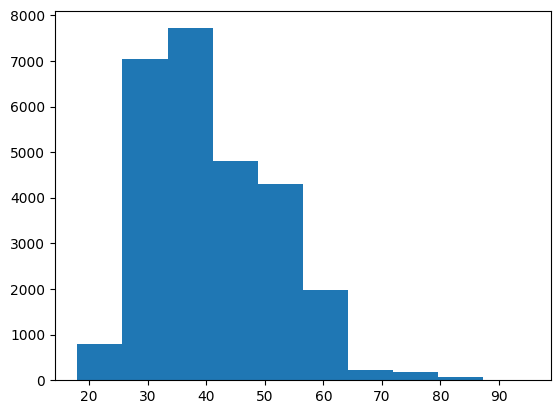

In [195]:
plt.hist(train["age"])

In [196]:
train["age_range"] = 1
train.loc[train["age"] < 20, "age_range"] = 1
train.loc[(train["age"] >= 20) & (train["age"] < 30), "age_range"] = 2
train.loc[(train["age"] >= 30) & (train["age"] < 40), "age_range"] = 3
train.loc[(train["age"] >= 40) & (train["age"] < 50), "age_range"] = 4
train.loc[(train["age"] >= 50) & (train["age"] < 60), "age_range"] = 5
train.loc[(train["age"] >= 60) & (train["age"] < 70), "age_range"] = 6
train.loc[(train["age"] >= 70) & (train["age"] < 80), "age_range"] = 7
train.loc[(train["age"] >= 80) & (train["age"] < 90), "age_range"] = 8
train.loc[train["age"] >= 90, "age_range"] = 9

In [197]:
test["age_range"] = 1
test.loc[test["age"] < 20, "age_range"] = 1
test.loc[(test["age"] >= 20) & (test["age"] < 30), "age_range"] = 2
test.loc[(test["age"] >= 30) & (test["age"] < 40), "age_range"] = 3
test.loc[(test["age"] >= 40) & (test["age"] < 50), "age_range"] = 4
test.loc[(test["age"] >= 50) & (test["age"] < 60), "age_range"] = 5
test.loc[(test["age"] >= 60) & (test["age"] < 70), "age_range"] = 6
test.loc[(test["age"] >= 70) & (test["age"] < 80), "age_range"] = 7
test.loc[(test["age"] >= 80) & (test["age"] < 90), "age_range"] = 8
test.loc[test["age"] >= 90, "age_range"] = 9

In [198]:
print(train["age_range"].value_counts(sort=True))

3    10836
4     6984
5     5102
2     3122
6      727
7      251
8       68
1       32
9        6
Name: age_range, dtype: int64


In [199]:
print(test["age_range"].value_counts(sort=True))

3    7253
4    4671
5    3308
2    2104
6     503
7     173
8      53
1      15
9       3
Name: age_range, dtype: int64


### balance (年間平均残高（€) ) をレンジ型へ修正

(array([4702., 3074., 2106., 1453., 1178.,  915.,  739.,  578.,  492.,
         434.,  424.,  332.,  306.,  246.,  229.,  210.,  150.,  153.,
         151.,  132.,  129.,  112.,   96.,   87.,   73.,   74.,   64.,
          66.,   55.,   51.,   44.,   49.,   52.,   43.,   31.,   36.,
          25.,   32.,   24.,   18.]),
 array([  100. ,   347.5,   595. ,   842.5,  1090. ,  1337.5,  1585. ,
         1832.5,  2080. ,  2327.5,  2575. ,  2822.5,  3070. ,  3317.5,
         3565. ,  3812.5,  4060. ,  4307.5,  4555. ,  4802.5,  5050. ,
         5297.5,  5545. ,  5792.5,  6040. ,  6287.5,  6535. ,  6782.5,
         7030. ,  7277.5,  7525. ,  7772.5,  8020. ,  8267.5,  8515. ,
         8762.5,  9010. ,  9257.5,  9505. ,  9752.5, 10000. ]),
 <BarContainer object of 40 artists>)

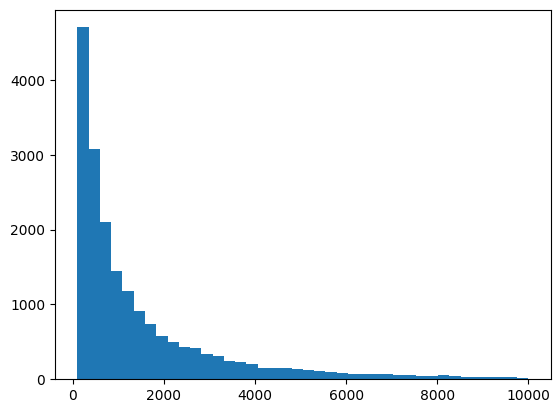

In [200]:
plt.hist(train["balance"], range=(100, 10000), bins=40)

In [201]:
train["balance_range"] = 1
train.loc[train["balance"] < 0, "balance_range"] = 0
train.loc[(train["balance"] >= 0) & (train["balance"] < 10), "balance_range"] = 1
train.loc[(train["balance"] >= 10) & (train["balance"] < 100), "balance_range"] = 2
train.loc[(train["balance"] >= 100) & (train["balance"] < 250), "balance_range"] = 3
train.loc[(train["balance"] >= 250) & (train["balance"] < 450), "balance_range"] = 4
train.loc[(train["balance"] >= 450) & (train["balance"] < 700), "balance_range"] = 5
train.loc[(train["balance"] >= 700) & (train["balance"] < 1200), "balance_range"] = 6
train.loc[(train["balance"] >= 1200) & (train["balance"] < 2000), "balance_range"] = 7
train.loc[(train["balance"] >= 2000) & (train["balance"] < 3500), "balance_range"] = 8
train.loc[train["balance"] >= 3500, "balance_range"] = 9

In [202]:
print(train["balance_range"].value_counts(sort=True))

4    3108
6    3077
3    2992
9    2742
1    2715
7    2707
5    2693
2    2498
8    2342
0    2254
Name: balance_range, dtype: int64


※ うまく分け切れているので "3500以上" としても問題無し

In [203]:
test["balance_range"] = 1
test.loc[test["balance"] < 0, "balance_range"] = 0
test.loc[(test["balance"] >= 0) & (test["balance"] < 10), "balance_range"] = 1
test.loc[(test["balance"] >= 10) & (test["balance"] < 100), "balance_range"] = 2
test.loc[(test["balance"] >= 100) & (test["balance"] < 250), "balance_range"] = 3
test.loc[(test["balance"] >= 250) & (test["balance"] < 450), "balance_range"] = 4
test.loc[(test["balance"] >= 450) & (test["balance"] < 700), "balance_range"] = 5
test.loc[(test["balance"] >= 700) & (test["balance"] < 1200), "balance_range"] = 6
test.loc[(test["balance"] >= 1200) & (test["balance"] < 2000), "balance_range"] = 7
test.loc[(test["balance"] >= 2000) & (test["balance"] < 3500), "balance_range"] = 8
test.loc[test["balance"] >= 3500, "balance_range"] = 9

In [204]:
print(test["balance_range"].value_counts(sort=True))

4    2092
6    2066
3    1995
9    1909
1    1828
5    1788
7    1750
2    1630
8    1513
0    1512
Name: balance_range, dtype: int64


### day (最終接触日) を一週間毎にレンジ型へ修正


In [205]:
train["day_range"] = 1
train.loc[train["day"] <= 7, "day_range"] = 1
train.loc[(train["day"] > 7) & (train["day"] <= 14), "day_range"] = 2
train.loc[(train["day"] > 14) & (train["day"] <= 21), "day_range"] = 3
train.loc[(train["day"] > 21) & (train["day"] <= 28), "day_range"] = 4
train.loc[train["day"] > 28, "day_range"] = 5

In [206]:
print(train["day_range"].value_counts(sort=True))

3    8280
2    6291
1    5878
4    4285
5    2394
Name: day_range, dtype: int64


In [207]:
test["day_range"] = 1
test.loc[test["day"] <= 7, "day_range"] = 1
test.loc[(test["day"] > 7) & (test["day"] <= 14), "day_range"] = 2
test.loc[(test["day"] > 14) & (test["day"] <= 21), "day_range"] = 3
test.loc[(test["day"] > 21) & (test["day"] <= 28), "day_range"] = 4
test.loc[test["day"] > 28, "day_range"] = 5

In [208]:
print(test["day_range"].value_counts(sort=True))

3    5620
2    4151
1    3920
4    2832
5    1560
Name: day_range, dtype: int64


## month (最終接触月) を上旬・中旬・下旬で修正

In [209]:
train["month_BME"] = 1
train.loc[(train["month"] == "jan") & (train["day_range"] == 1), "month_BME"] = 3
train.loc[(train["month"] == "jan") & (train["day_range"] == 2), "month_BME"] = 2
train.loc[(train["month"] == "jan") & (train["day_range"] == 3), "month_BME"] = 1

train.loc[(train["month"] == "feb") & (train["day_range"] == 1), "month_BME"] = 6
train.loc[(train["month"] == "feb") & (train["day_range"] == 2), "month_BME"] = 5
train.loc[(train["month"] == "feb") & (train["day_range"] == 3), "month_BME"] = 4

train.loc[(train["month"] == "mar") & (train["day_range"] == 1), "month_BME"] = 9
train.loc[(train["month"] == "mar") & (train["day_range"] == 2), "month_BME"] = 8
train.loc[(train["month"] == "mar") & (train["day_range"] == 3), "month_BME"] = 7

train.loc[(train["month"] == "apr") & (train["day_range"] == 1), "month_BME"] = 12
train.loc[(train["month"] == "apr") & (train["day_range"] == 2), "month_BME"] = 11
train.loc[(train["month"] == "apr") & (train["day_range"] == 3), "month_BME"] = 10

train.loc[(train["month"] == "may") & (train["day_range"] == 1), "month_BME"] = 15
train.loc[(train["month"] == "may") & (train["day_range"] == 2), "month_BME"] = 14
train.loc[(train["month"] == "may") & (train["day_range"] == 3), "month_BME"] = 13

train.loc[(train["month"] == "jun") & (train["day_range"] == 1), "month_BME"] = 18
train.loc[(train["month"] == "jun") & (train["day_range"] == 2), "month_BME"] = 17
train.loc[(train["month"] == "jun") & (train["day_range"] == 3), "month_BME"] = 16

train.loc[(train["month"] == "jul") & (train["day_range"] == 1), "month_BME"] = 21
train.loc[(train["month"] == "jul") & (train["day_range"] == 2), "month_BME"] = 20
train.loc[(train["month"] == "jul") & (train["day_range"] == 3), "month_BME"] = 19

train.loc[(train["month"] == "aug") & (train["day_range"] == 1), "month_BME"] = 24
train.loc[(train["month"] == "aug") & (train["day_range"] == 2), "month_BME"] = 23
train.loc[(train["month"] == "aug") & (train["day_range"] == 3), "month_BME"] = 22

train.loc[(train["month"] == "sep") & (train["day_range"] == 1), "month_BME"] = 27
train.loc[(train["month"] == "sep") & (train["day_range"] == 2), "month_BME"] = 26
train.loc[(train["month"] == "sep") & (train["day_range"] == 3), "month_BME"] = 25

train.loc[(train["month"] == "oct") & (train["day_range"] == 1), "month_BME"] = 30
train.loc[(train["month"] == "oct") & (train["day_range"] == 2), "month_BME"] = 29
train.loc[(train["month"] == "oct") & (train["day_range"] == 3), "month_BME"] = 28

train.loc[(train["month"] == "nov") & (train["day_range"] == 1), "month_BME"] = 33
train.loc[(train["month"] == "nov") & (train["day_range"] == 2), "month_BME"] = 32
train.loc[(train["month"] == "nov") & (train["day_range"] == 3), "month_BME"] = 31

train.loc[(train["month"] == "dec") & (train["day_range"] == 1), "month_BME"] = 36
train.loc[(train["month"] == "dec") & (train["day_range"] == 2), "month_BME"] = 35
train.loc[(train["month"] == "dec") & (train["day_range"] == 3), "month_BME"] = 34

In [210]:
test["month_BME"] = 1
test.loc[(test["month"] == "jan") & (test["day_range"] == 1), "month_BME"] = 3
test.loc[(test["month"] == "jan") & (test["day_range"] == 2), "month_BME"] = 2
test.loc[(test["month"] == "jan") & (test["day_range"] == 3), "month_BME"] = 1

test.loc[(test["month"] == "feb") & (test["day_range"] == 1), "month_BME"] = 6
test.loc[(test["month"] == "feb") & (test["day_range"] == 2), "month_BME"] = 5
test.loc[(test["month"] == "feb") & (test["day_range"] == 3), "month_BME"] = 4

test.loc[(test["month"] == "mar") & (test["day_range"] == 1), "month_BME"] = 9
test.loc[(test["month"] == "mar") & (test["day_range"] == 2), "month_BME"] = 8
test.loc[(test["month"] == "mar") & (test["day_range"] == 3), "month_BME"] = 7

test.loc[(test["month"] == "apr") & (test["day_range"] == 1), "month_BME"] = 12
test.loc[(test["month"] == "apr") & (test["day_range"] == 2), "month_BME"] = 11
test.loc[(test["month"] == "apr") & (test["day_range"] == 3), "month_BME"] = 10

test.loc[(test["month"] == "may") & (test["day_range"] == 1), "month_BME"] = 15
test.loc[(test["month"] == "may") & (test["day_range"] == 2), "month_BME"] = 14
test.loc[(test["month"] == "may") & (test["day_range"] == 3), "month_BME"] = 13

test.loc[(test["month"] == "jun") & (test["day_range"] == 1), "month_BME"] = 18
test.loc[(test["month"] == "jun") & (test["day_range"] == 2), "month_BME"] = 17
test.loc[(test["month"] == "jun") & (test["day_range"] == 3), "month_BME"] = 16

test.loc[(test["month"] == "jul") & (test["day_range"] == 1), "month_BME"] = 21
test.loc[(test["month"] == "jul") & (test["day_range"] == 2), "month_BME"] = 20
test.loc[(test["month"] == "jul") & (test["day_range"] == 3), "month_BME"] = 19

test.loc[(test["month"] == "aug") & (test["day_range"] == 1), "month_BME"] = 24
test.loc[(test["month"] == "aug") & (test["day_range"] == 2), "month_BME"] = 23
test.loc[(test["month"] == "aug") & (test["day_range"] == 3), "month_BME"] = 22

test.loc[(test["month"] == "sep") & (test["day_range"] == 1), "month_BME"] = 27
test.loc[(test["month"] == "sep") & (test["day_range"] == 2), "month_BME"] = 26
test.loc[(test["month"] == "sep") & (test["day_range"] == 3), "month_BME"] = 25

test.loc[(test["month"] == "oct") & (test["day_range"] == 1), "month_BME"] = 30
test.loc[(test["month"] == "oct") & (test["day_range"] == 2), "month_BME"] = 29
test.loc[(test["month"] == "oct") & (test["day_range"] == 3), "month_BME"] = 28

test.loc[(test["month"] == "nov") & (test["day_range"] == 1), "month_BME"] = 33
test.loc[(test["month"] == "nov") & (test["day_range"] == 2), "month_BME"] = 32
test.loc[(test["month"] == "nov") & (test["day_range"] == 3), "month_BME"] = 31

test.loc[(test["month"] == "dec") & (test["day_range"] == 1), "month_BME"] = 36
test.loc[(test["month"] == "dec") & (test["day_range"] == 2), "month_BME"] = 35
test.loc[(test["month"] == "dec") & (test["day_range"] == 3), "month_BME"] = 34

# モデル構築

### 前準備及び複製

機械学習モデルに適した形にするために、カテゴリカル変数(質的データ)を数値ラベルに置き換える

* （今回は）勾配ブースティング木というアルゴリズムを学習に用いる予定の為、One-Hot-Encodingではなく、Label Encodingを用いる

In [211]:
from sklearn.preprocessing import LabelEncoder

train_le = train.copy()
test_le = test.copy()
le = LabelEncoder()

for col in ["job","marital","education","default","housing","loan","contact","month","poutcome"]:
    le.fit(pd.concat([train_le[col], test_le[col]], axis=0))
    train_le[col] = le.transform(train[col])
    test_le[col] = le.transform(test[col])

# データの保存は今回はしない
# train.to_csv("train_encoded.csv", index=False)
# test.to_csv("test_encoded.csv", index=False)

y との相関について変数を作成

In [212]:
corr_train = train.corr()
corr_train_le = train_le.corr()

corr_y = pd.DataFrame(index=train.columns, data=corr_train["y"])
corr_le_y = pd.DataFrame(index=train_le.columns, data=corr_train_le["y"])

# それぞれ出力
print (corr_train)
print (corr_train_le)

                     id       age   balance       day  duration  campaign  \
id             1.000000 -0.005716 -0.000484  0.002974  0.002705  0.016867   
age           -0.005716  1.000000  0.095343 -0.008518 -0.005309 -0.001340   
balance       -0.000484  0.095343  1.000000  0.002067  0.019923 -0.016295   
day            0.002974 -0.008518  0.002067  1.000000 -0.032453  0.164880   
duration       0.002705 -0.005309  0.019923 -0.032453  1.000000 -0.087771   
campaign       0.016867 -0.001340 -0.016295  0.164880 -0.087771  1.000000   
pdays         -0.004526 -0.025381  0.003511 -0.096870  0.002006 -0.086103   
previous      -0.005425  0.002946  0.012483 -0.050009  0.002489 -0.031557   
y             -0.003555  0.020892  0.045826 -0.031058  0.401390 -0.076118   
age_range     -0.007517  0.964076  0.093385 -0.004510 -0.005215  0.001163   
balance_range  0.013812  0.112212  0.579696 -0.002144  0.044086 -0.034586   
day_range      0.004110 -0.006198 -0.001854  0.970515 -0.027796  0.155130   

### 不必要なものを取り除く(多重共線性の回避)

ここでは、先ほど修正した特徴量を取り除く

In [213]:
train_le2 = train_le.drop(["id", "age", "balance", "day", "month", "campaign", "previous"], axis=1)
print(train_le2.columns)
test_le2 = test_le.drop(["id", "age", "balance", "day", "month", "campaign", "previous"], axis=1)
print(test_le2.columns)

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'duration', 'pdays', 'poutcome', 'y', 'age_range', 'balance_range',
       'day_range', 'month_BME'],
      dtype='object')
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'duration', 'pdays', 'poutcome', 'age_range', 'balance_range',
       'day_range', 'month_BME'],
      dtype='object')


### 訓練用データとテストデータへの分割(ホールドアウト)



In [214]:
from sklearn.model_selection import train_test_split

train_x = train_le2.drop(["y"], axis=1)
train_y = train_le2["y"]

train_train_x, train_test_x, train_train_y, train_test_y = train_test_split(train_x, train_y, test_size=0.25, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(train_train_x, train_train_y, test_size=0.25, random_state=10)

early_stoppingを用いるため、専用の評価データも作成し、分割しておく

### LightGBMバイナリファイルへ定義・保存

In [215]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

* 勾配ブースティングの手法
* 決定木を勾配ブースティングでアンサンブル学習
* LightGBMは葉毎の学習

### パラメータの設定

In [216]:
params = {'objective': 'binary',
         'metric': 'l2',
         'random_state': 10,
         'boosting_type': 'gbdt',
         'verbose': -1
         }

> "objective" - 最小化させるべき損失関数
>
> "metric" - 学習時の評価指標
>
> "random_state" - 乱数シード
>
> "boosting_type" - ブースティングのアルゴリズム
>
> "verbose" - Warningの非表示化

### 実行

early_stoppingを指定してLightGBM学習

In [217]:
from sklearn.metrics import mean_squared_error

verbose_eval = 1

gbm = lgb.train(params, lgb_train,
                valid_sets=[lgb_eval],
                num_boost_round=10000,
                callbacks=[lgb.early_stopping(stopping_rounds=1000,
                                verbose=True),
                           lgb.log_evaluation(verbose_eval)]
                )

[1]	valid_0's l2: 0.0987517
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l2: 0.0934595
[3]	valid_0's l2: 0.0892235
[4]	valid_0's l2: 0.0857904
[5]	valid_0's l2: 0.0830441
[6]	valid_0's l2: 0.080641
[7]	valid_0's l2: 0.0787389
[8]	valid_0's l2: 0.0771731
[9]	valid_0's l2: 0.0757787
[10]	valid_0's l2: 0.0746715
[11]	valid_0's l2: 0.0737233
[12]	valid_0's l2: 0.0728577
[13]	valid_0's l2: 0.0720247
[14]	valid_0's l2: 0.0714792
[15]	valid_0's l2: 0.0708654
[16]	valid_0's l2: 0.0701795
[17]	valid_0's l2: 0.0698297
[18]	valid_0's l2: 0.0696257
[19]	valid_0's l2: 0.0692867
[20]	valid_0's l2: 0.0690848
[21]	valid_0's l2: 0.0687304
[22]	valid_0's l2: 0.0684907
[23]	valid_0's l2: 0.0682593
[24]	valid_0's l2: 0.0679222
[25]	valid_0's l2: 0.0678112
[26]	valid_0's l2: 0.067839
[27]	valid_0's l2: 0.0677549
[28]	valid_0's l2: 0.0674764
[29]	valid_0's l2: 0.0673318
[30]	valid_0's l2: 0.0672603
[31]	valid_0's l2: 0.067274
[32]	valid_0's l2: 0.0672039
[33]	valid_0's l2: 0.

# モデル評価

## バリデーション(評価)

### AUCスコアの確認

In [218]:
from sklearn.metrics import roc_auc_score
pred_test = gbm.predict(data = train_test_x, num_iteration = gbm.best_iteration)

roc_train_test = roc_auc_score(train_test_y, pred_test)
print(roc_train_test)

0.922273691446001


### 各変数の重要度に関するグラフ

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

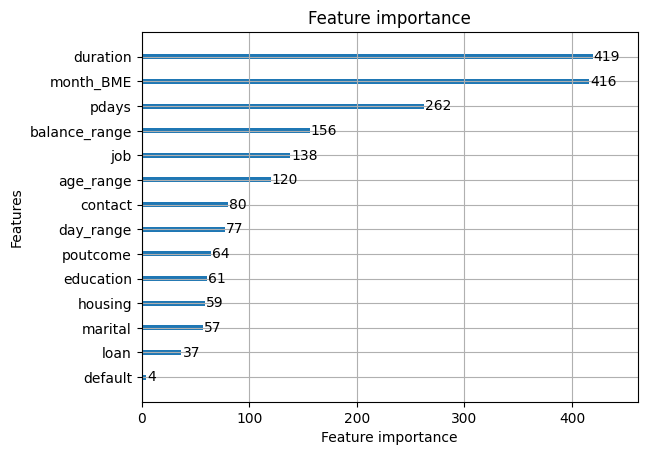

In [219]:
lgb.plot_importance(gbm, max_num_features = 16)

# 予測・提出

In [220]:
# predict
pred_test = gbm.predict(test_le2, num_iteration = gbm.best_iteration)

# submit
submit_gbm = pd.read_csv("submit_sample.csv", names=("id", "pred"))  #提出形式のサンプルデータ読み込み
submit_gbm["pred"] = pred_test

# to_csv
submit_gbm.to_csv("signate.csv")